In [1]:
import numpy as np
import random
import keras
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import initializers, regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [9]:
q = 0.1
fname = "DATA/dataRBM_q"+str(q)+".csv"
v = np.loadtxt(fname, delimiter = ",", dtype = int)
N = len(v)
L = len(v[0])

SPINS = False
if SPINS:
    vmin = -1
    GAP = 2
    v = 2*v - 1
else: 
    vmin = 0
    GAP = 1

v0 = np.copy(v)
    
for n in range(10):
    print(v[n])
print(...)

[0 1 0 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[0 1 1 1 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 0 0 1 0 0 0]
[0 1 1 0 1 1 0 0]
[1 1 0 0 0 0 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]
Ellipsis


In [3]:
#n hidden units
M = 3
sigma = np.sqrt(4/(L+M))
np.random.seed(12345)
w = sigma * (2*np.random.rand(L,M) - 1)
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

print("w = ", w)
print("a = ", a)
print("b = ", b)

w =  [[ 0.5181365  -0.22145941 -0.38120826]
 [-0.35631371  0.08167946  0.11523125]
 [ 0.56022559  0.18473853  0.3001927 ]
 [ 0.18521223  0.2987553   0.55635686]
 [-0.59290602 -0.47464594 -0.24277246]
 [ 0.18863898  0.373648    0.44886104]
 [ 0.56038609  0.26977468  0.17183171]
 [ 0.26225893 -0.03907707 -0.21035279]]
a =  [-0.07279134  0.27701546  0.59580401  0.21331772  0.35074515 -0.39689234
 -0.57064124  0.36226014]
b =  [0. 0. 0.]


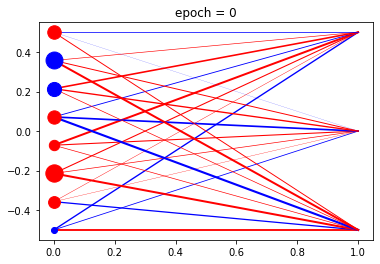

In [4]:
def create_coord(np, x0):
    x = [x0] * np
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1) - 0.5
    return (x,y)

(x1,y1) = create_coord(L,0)
(x2,y2) = create_coord(M,1)

def mycolor(val):
    if val > 0: 
        return "red"
    elif val < 0: 
        return "blue"
    return "black"

def plotgraph(epoch = 0):
    A = 2/w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i], x2[j]), (y1[i], y2[j]), mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder = 1, lw = A*np.abs(w[i][j]))
    A = 300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s = A*np.abs(a[i]), zorder = 2, c = mycolor(a[i]))
    plt.title("epoch = " + str(epoch))
    plt.show()
    
plotgraph()

In [5]:
def activate(v_in, wei, bias, DE, info=False):
    act = np.dot(v_in, wei) + bias
    prob = 1/(1+np.exp(-DE*act))
    n = len(act)
    v_out = np.full(n,vmin)
    v_out[np.random.random_sample(n) < prob] = 1
    if info: 
        print("input=", v_in)
        print(f"act = {act}")
        print(f"prob = {prob}")
        print(f"out = {v_out}")

    return(v_out)

activate(v[0], w, b, GAP, info = True)

input= [0 1 0 0 1 0 1 1]
act = [-0.12657471 -0.16226887 -0.16606229]
prob = [0.4683985  0.45952156 0.45857957]
out = [0 1 0]


array([0, 1, 0])

In [6]:
np.random.seed(12345)

l_rate = 1.0
#minibatches
mini, m = 500, 0
#epochs
nepoch = 50

for epoch in range(1,1+nepoch):
    for n in range(N):
        if m == 0:
            #initialize
            v_data, v_model = np.zeros(L), np.zeros(L)
            h_data, h_model = np.zeros(M), np.zeros(M)
            vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))
        
        #positive CD phase
        h = activate(v[n], w, b, GAP)
        #negative CD phase
        vf = activate(h, w.T, a, GAP)
        #second positive CD phase
        hf = activate(vf, w, b, GAP)
        
        v_data += v[n]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[n].T, h)
        
        m+=1
        
        if m==mini:
            C = l_rate/mini
            dw = C*(vh_data-vh_model)
            da = C*(v_data-v_model)
            db = C*(h_data-h_model)
            if epoch <= 2 and n<mini:
                print("----epoch=", epoch, "  n= ", n, "   m= ",m)
                print(f"dw = {dw}")
                print(f"da = {da}")
                print(f"db = {db}")
            w += dw
            a += da
            b += db
            m = 0
            
        #randomize order
        np.random.shuffle(v)
        #lrate decaying as a power law
        l_rate = l_rate / (0.05*l_rate+1) 

    if epoch%5 == 0:
        plotgraph(epoch)
        print("l_rate", l_rate)

----epoch= 1   n=  499    m=  500
dw = [[0.01233141 0.00824663 0.00963391]
 [0.01156069 0.00917148 0.01071291]
 [0.01348748 0.01186898 0.01464355]
 [0.01364162 0.01179191 0.0144894 ]
 [0.01086705 0.0088632  0.01186898]
 [0.01171484 0.01001927 0.01279383]
 [0.01441233 0.01148362 0.01156069]
 [0.01533719 0.01163776 0.01202312]]
da = [-0.00115607 -0.00177264 -0.00978805 -0.00855491  0.00277457 -0.00231214
 -0.00154143 -0.00030829]
db = [-0.00254335 -0.00084778 -0.00100193]


KeyboardInterrupt: 

---- epoch = 1  n= 499  m= 500
dw= [[-0.022 -0.032 -0.006]
 [ 0.018 -0.016  0.024]
 [-0.014 -0.034  0.008]
 [-0.008 -0.028 -0.01 ]
 [-0.006 -0.002  0.03 ]
 [-0.002 -0.024  0.01 ]
 [-0.008 -0.012  0.024]
 [-0.022 -0.022  0.012]]
da= [-0.036  0.02  -0.006 -0.03   0.002 -0.02   0.024 -0.032]
db= [-0.002 -0.038  0.022]
---- epoch = 2  n= 499  m= 500
dw= [[-0.00952381 -0.00571429 -0.00952381]
 [-0.02666667 -0.01333333 -0.03619048]
 [-0.02095238 -0.01142857 -0.03047619]
 [ 0.01714286  0.02666667  0.02857143]
 [ 0.          0.02666667  0.00952381]
 [ 0.00952381  0.0152381   0.00571429]
 [-0.00571429  0.         -0.00380952]
 [-0.0152381   0.00952381  0.00952381]]
da= [-0.00952381 -0.04380952 -0.04190476  0.03428571 -0.00380952  0.0152381
 -0.01714286  0.00190476]
db= [-0.00761905  0.0152381  -0.00380952]


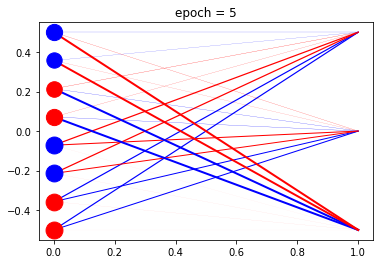

learning rate 0.7999999999999998


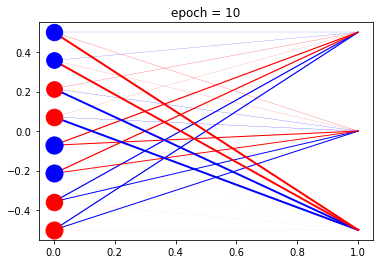

learning rate 0.6666666666666663


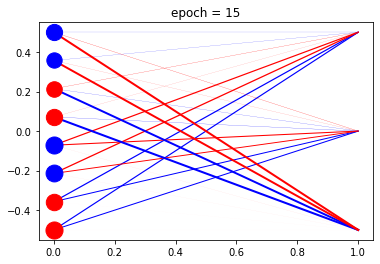

learning rate 0.5714285714285713


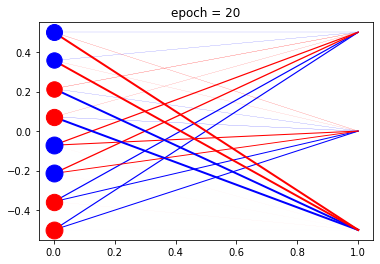

learning rate 0.5


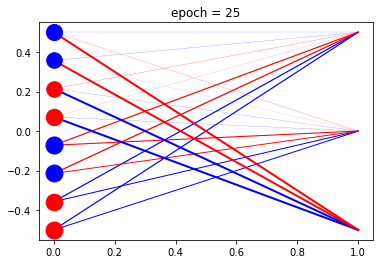

learning rate 0.4444444444444445


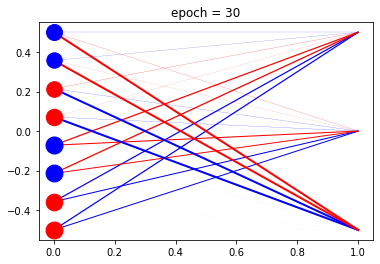

learning rate 0.4000000000000001


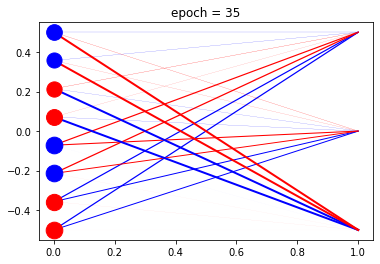

learning rate 0.3636363636363637


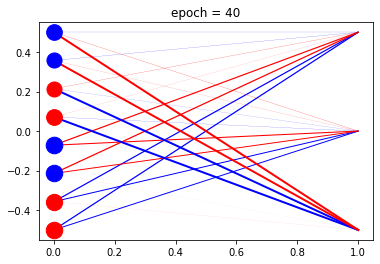

learning rate 0.3333333333333335


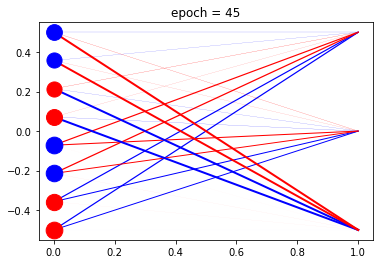

learning rate 0.3076923076923079


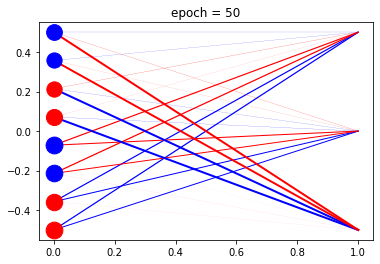

learning rate 0.28571428571428586


In [10]:
np.random.seed(12345)

l_rate = 1.0
#minibatches
mini, m = 500, 0
#epochs
nepoch=50
for epoch in range(1,1+nepoch):
    for n in range(N):
        if m==0:
            #initialize
            v_data, v_model = np.zeros(L), np.zeros(L)
            h_data, h_model = np.zeros(M), np.zeros(M)
            vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))
        #positive CD phase
        h = activate(v[n],w,b,GAP)
        #negative CD phase
        vf = activate(h,w.T, a,GAP)
        #positive CD phase
        hf = activate(vf,w,b,GAP)
        
        v_data += v[n]
        v_model += vf #fantasy
        h_data += h
        h_model += hf
        vh_data += np.outer(v[n].T, h)
        vh_model += np.outer(vf.T, hf)
        m+=1
        
        if m==mini:
            C = l_rate/mini
            dw=C*(vh_data-vh_model)
            da=C*(v_data-v_model)
            db=C*(h_data-h_model)
            if epoch<=2 and n<=mini:
                print("---- epoch =", epoch," n=",n," m=",m)
                print("dw=",dw)
                print("da=",da)
                print("db=",db)
                
            w +=dw
            a +=da
            b +=db
            m=0
    #randomize order
    np.random.shuffle(v) #the rows
    l_rate = l_rate/(0.05*l_rate+1)
    if epoch%5 ==0:
        plotgraph(epoch)
        print("learning rate", l_rate)

In [11]:
v1 = np.full((N,L), vmin)
for n in range(N):
    h = activate(v0[n], w,b,GAP)
    v1[n] = activate(h,w.T,a,GAP)
    
for n in range(10):
    print((v0[n]).astype(int), (v1[n]).astype(int))

[0 1 0 0 1 0 1 1] [1 1 0 0 0 0 1 1]
[1 1 0 1 1 0 0 1] [1 1 0 0 1 1 0 0]
[0 1 1 1 0 0 1 1] [0 0 0 1 0 0 0 1]
[0 0 1 1 1 1 0 0] [0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0] [0 0 1 1 0 0 1 1]
[1 1 0 0 1 0 0 0] [0 1 0 0 1 1 1 0]
[0 1 1 0 1 1 0 0] [0 0 0 1 0 1 0 0]
[1 1 0 0 0 0 1 1] [1 1 0 0 0 0 1 1]
[1 0 0 1 1 1 0 1] [1 0 0 0 1 1 1 0]
[1 0 0 0 0 0 1 0] [1 1 0 0 0 0 1 1]
